<a href="https://colab.research.google.com/github/AbyssGazer-Oliver/Machine-Learning/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [ ]:
from tqdm import tqdm
import requests
import os
import zipfile

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Get file names
matlab_dir = 'matlab'
digits_fn =  os.path.join(matlab_dir,'emnist-digits.mat')
letters_fn = os.path.join(matlab_dir,'emnist-letters.mat')

# Check if files exists
if os.path.exists(matlab_dir):
    if os.path.exists(digits_fn) and os.path.exists(letters_fn):
        print('Files already downloaded')
        files_exists = True
else:
    files_exists = False
    
if not files_exists:
    # First download the zip file if needed
    src_url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    dst_fn = 'matlab.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files already downloaded


In [ ]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [ ]:
# TODO 1:  Load the digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist(digits_fn)

240000 training samples, 40000 test samples loaded


In [ ]:
# TODO 2:  Load the digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist(letters_fn)

124800 training samples, 20800 test samples loaded


In [ ]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y) 

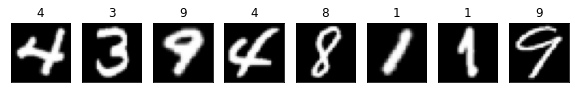

In [ ]:
# TODO 3:  Plot 8 random samples from the training data of the digits
I=np.random.permutation(Xtr_dig.shape[0])
plt.figure(figsize=(10,20))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt_digit(Xtr_dig[I[i],:], ytr_dig[I[i]])

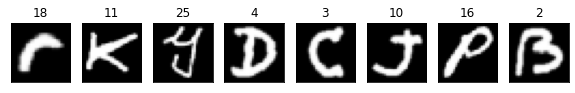

In [ ]:
# TODO 4:  Plot 8 random samples from the training data of the letters
I=np.random.permutation(Xtr_let.shape[0])
plt.figure(figsize=(10,20))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt_digit(Xtr_let[I[i],:], ytr_let[I[i]])

In [ ]:
remove_list = np.array([9,12,15])

# TODO 5:  Create arrays with labels 9, 12 and 15 removed
def remove_select(X,y):
  I=np.all(y[:,None]!=remove_list[None,:], axis=1)
  X_select=X[I,:]
  y_select=y[I]
  return X_select,y_select

Xtr_let_rem, ytr_let_rem = remove_select(Xtr_let,ytr_let)
Xts_let_rem, yts_let_rem = remove_select(Xts_let,yts_let)

In [ ]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# TODO 6 Create sub-sampled training and test data\
def random_select(X,y,n):
  I=np.random.permutation(X.shape[0])
  X1=X[I[:n],:]
  y1=y[I[:n]]
  return X1,y1
  
Xtr1_dig, ytr1_dig = random_select(Xtr_dig,ytr_dig,ntr_dig)
Xts1_dig, yts1_dig = random_select(Xts_dig,yts_dig,nts_dig)
Xtr1_let, ytr1_let = random_select(Xtr_let_rem,ytr_let_rem,ntr_let)
Xts1_let, yts1_let = random_select(Xts_let_rem,yts_let_rem,nts_let)

In [ ]:
# TODO 7:  Create combined letter and digit training and test data
def combine(X1,X2,y,n):
  X_=np.vstack((X1,X2))
  y_=np.hstack((y,10*np.ones(n,dtype='int')))
  return X_,y_

Xtr, ytr = combine(Xtr1_dig,Xtr1_let,ytr1_dig,ntr_let)
Xts, yts = combine(Xts1_dig,Xts1_let,yts1_dig,nts_let)

In [ ]:
# TODO 8:  Rescale the data from -1 to 1
Xtr1 = 2*Xtr/255.0-1
Xts1 = 2*Xts/255.0-1

In [ ]:
from sklearn import svm

# TODO 9:  Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,kernel="rbf", C=2.8, gamma=.0073, verbose=10)

In [ ]:
# TODO 10:  Fit the classifier on the training data.
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, gamma=0.0073, verbose=10)

In [ ]:
# TODO 11:  Measure error on the test data
yhat=svc.predict(Xts1)
print(np.mean(yhat==yts))

0.9028333333333334


In [ ]:
# TODO 12:  Print a confusion matrix
from sklearn.metrics import confusion_matrix
C=confusion_matrix(yts,yhat)
C_sum=np.sum(C,1)
C_normal=C/C_sum[np.newaxis,:]
print(np.array_str(C_normal, precision=3, suppress_small=True))

[[0.969 0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.013]
 [0.    0.98  0.002 0.    0.    0.    0.    0.    0.002 0.002 0.007]
 [0.004 0.002 0.925 0.002 0.    0.    0.    0.006 0.002 0.    0.03 ]
 [0.    0.    0.004 0.949 0.    0.009 0.    0.002 0.012 0.006 0.006]
 [0.    0.    0.    0.    0.9   0.    0.    0.    0.    0.002 0.047]
 [0.004 0.002 0.    0.022 0.006 0.899 0.004 0.    0.002 0.002 0.035]
 [0.004 0.    0.    0.    0.    0.    0.95  0.    0.    0.    0.023]
 [0.    0.004 0.004 0.004 0.006 0.    0.    0.952 0.004 0.013 0.006]
 [0.004 0.004 0.    0.004 0.002 0.006 0.    0.002 0.904 0.01  0.032]
 [0.002 0.002 0.    0.007 0.015 0.    0.    0.02  0.01  0.937 0.006]
 [0.039 0.045 0.069 0.055 0.061 0.095 0.048 0.02  0.044 0.048 0.736]]


In [ ]:
# TODO 13:  Print above two error rates
err_mis_letter=np.mean((yhat== 10)&(yts< 10))
err_mis_digit=np.mean((yhat< 10)&(yts== 10))
print("The fraction of digits mislabeled as letters is",err_mis_letter)
print("The fraction of letters mislabeled as digits is",err_mis_digit)

The fraction of digits mislabeled as letters is 0.034166666666666665
The fraction of letters mislabeled as digits is 0.044


In [ ]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO 14:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i, C in enumerate(C_test):
  for j, gam in enumerate(gam_test):
    svc=svm.SVC(probability=False,kernel="rbf", C=C, gamma=gam,verbose=10)
    svc.fit(Xtr1,ytr)
    yhat=svc.predict(Xts1)
    acc[i,j]=np.mean(yhat==yts)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
# TODO 15:  Print the accuracy matrix
print(acc)

[[0.50983333 0.81383333 0.22833333]
 [0.81816667 0.8965     0.393     ]
 [0.85366667 0.90766667 0.44366667]]


In [ ]:
# TODO 16:  Print the maximum accuracy and the corresponding best C and gamma
I_max=np.argmax(acc)
i_max,j_max=np.unravel_index(I_max,(nC,ngam))
print("The maximum accuracy is",np.max(acc))
print("The best C is",C_test[i_max])
print("The best gamma is",gam_test[j_max])

The maximum accuracy is 0.9076666666666666
The best C is 10
The best gamma is 0.01


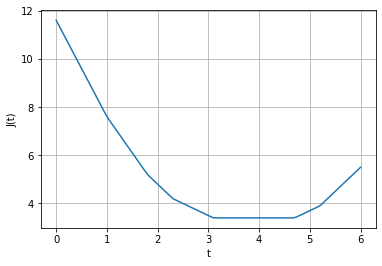

In [ ]:
x=np.array([0,1.3,2.1,2.8,4.2,5.7])
y=np.array([-1,-1,-1,1,-1,1])
t=np.linspace(0,6,100)
J=[]
for i in t:
  z=x-i
  Jt=np.sum(np.maximum(0,1-y*z))
  J.append(Jt)
J=np.array(J)
plt.plot(t,J)
plt.xlabel('t')
plt.ylabel('J(t)')
plt.grid()
Xmat=x.reshape([4,4])

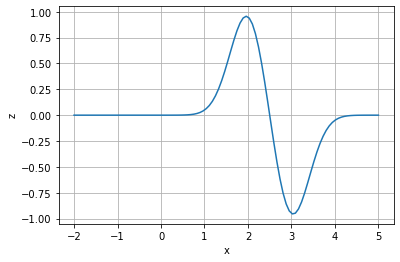

In [ ]:
x=np.array([0,1,2,3])
y=np.array([1,-1,1,-1])
a=np.array([0,0,1,1])
gam=3
x_=np.linspace(-2,5,100)
x_mat,xmat=np.meshgrid(x_,x)
dist=(x_mat-xmat)**2
z=(y*a).dot(np.exp(-gam*dist))
plt.plot(x_,z)
plt.xlabel('x')
plt.ylabel('z')
plt.grid()

In [ ]:
yhat=